In [ ]:
# mamba create -n torchvinecopulib python=3.12 -y
# mamba activate torchvinecopulib
# mamba install -c conda-forge uv
# # mamba install -c conda-forge \
# #     "numpy>=2" \
# #     scipy \
# #     coverage \
# #     datasets \
# #     furo \
# #     ipykernel \
# #     kagglehub \
# #     lightgbm \
# #     matplotlib \
# #     pandas \
# #     pot \
# #     pytest \
# #     python-dotenv \
# #     pyvinecopulib \
# #     ruff \
# #     scikit-learn \
# #     sklearn-quantile \
# #     sphinx \
# #     tokenize-rt \
# #     ucimlrepo \
# #     yfinance \
# #     uv

# uv pip install -e ".[cu124]"
# uv pip install lightning torchvision ipykernel seaborn

In [ ]:
import os
from dataclasses import dataclass

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import pyvinecopulib as pvc
import seaborn as sns
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import torchvinecopulib as tvc


@dataclass
class Config:
    data_dir: str = os.environ.get("PATH_DATASETS", ".")
    save_dir: str = "logs/"
    batch_size: int = 256 if torch.cuda.is_available() else 64
    max_epochs: int = 3
    accelerator: str = "auto"
    devices: int = 1


config = Config()

In [9]:
class LitMNISTAutoencoder(pl.LightningModule):
    def __init__(
        self,
        data_dir: str = config.data_dir,
        hidden_size: int = 64,
        learning_rate: float = 2e-4,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        flat_dim = channels * width * height

        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )

        # Encoder: flatten → hidden → latent
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 10),
        )

        # Decoder: latent → hidden → image
        self.decoder = nn.Sequential(
            nn.Linear(10, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, flat_dim),
            nn.Sigmoid(),  # Ensure output in [0,1] range
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat.view(-1, *self.dims)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log("test_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=config.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=config.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=config.batch_size)


In [10]:
# Instantiate the LitMNISTAutoencoder
model = LitMNISTAutoencoder()

# Instantiate a checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # metric to monitor
    mode="min",  # "min" for val_loss, "max" for accuracy
    save_top_k=1,  # only save the best model
    save_last=True,  # also save the last epoch
    dirpath=config.save_dir,  # where to save
    filename="{epoch:02d}-{val_loss:.4f}",  # optional: filename format
)

# Instantiate a PyTorch Lightning trainer with the specified configuration
trainer = pl.Trainer(
    accelerator=config.accelerator,
    devices=config.devices,
    max_epochs=config.max_epochs,
    logger=CSVLogger(save_dir=config.save_dir),
    callbacks=[checkpoint_callback],
)

# Train the model using the trainer
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/thibault/torchvinecopulib/examples/logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 52.6 K | train
1 | decoder | Sequential | 53.4 K | train
-----------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 215/215 [00:09<00:00, 23.83it/s, v_num=2, train_loss=0.718, val_loss=0.706]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 215/215 [00:09<00:00, 23.80it/s, v_num=2, train_loss=0.718, val_loss=0.706]


In [11]:
trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at /home/thibault/torchvinecopulib/examples/logs/epoch=02-val_loss=0.7063.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/thibault/torchvinecopulib/examples/logs/epoch=02-val_loss=0.7063.ckpt
/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 33.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7103996872901917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7103996872901917}]

,test_loss,train_loss,val_loss
epoch,,,
0,NaN,1.151680,NaN
0,NaN,0.845215,NaN
0,NaN,0.795708,NaN
0,NaN,0.791115,NaN
0,NaN,NaN,0.800101


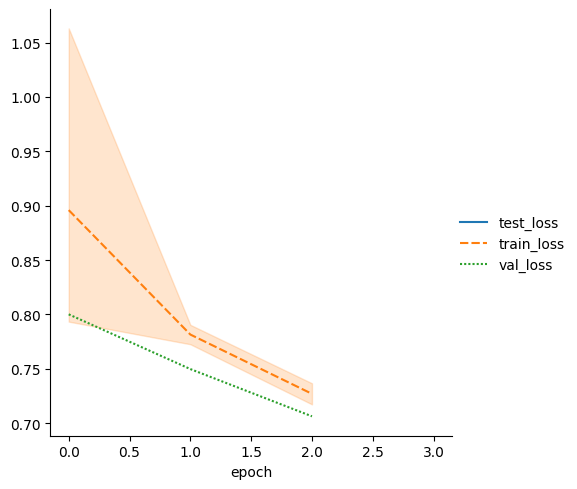

In [16]:
# Read in the training metrics from the CSV file generated by the logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Remove the "step" column, which is not needed for our analysis
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace=True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis=1, how="all").head())

# Create a line plot of the training metrics using Seaborn
sns.relplot(data=metrics, kind="line")

In [17]:
# last_path = os.path.join(config.save_dir, "last.ckpt")  # default naming
# Load best checkpoint
inference_model = LitMNISTAutoencoder.load_from_checkpoint(
    checkpoint_path=checkpoint_callback.best_model_path
)
inference_model.eval()
inference_model.freeze()

inference_model.prepare_data()
inference_model.setup(stage="fit")  # sets model.mnist_train, model.mnist_val
train_loader = model.train_dataloader()

In [18]:
representations = []
labels = []

for batch in train_loader:
    x, y = batch
    with torch.no_grad():
        z = model.encoder(x)
    representations.append(z)
    labels.append(y)

# Concatenate into a single tensor
representations = torch.cat(representations, dim=0)
labels = torch.cat(labels, dim=0)

In [74]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_step_grid = 128
is_cop_scale = False

# Convert to numpy
reps_np = representations.cpu().numpy()
labels_np = labels.cpu().numpy()

# Prepare containers
class_vines = {}
unique_classes = np.unique(labels_np)

for cls in unique_classes:
    # 1. Select samples for this class
    class_mask = labels_np == cls
    x_cls = reps_np[class_mask]

    # 2. Convert to pseudo-observations
    u_cls = pvc.to_pseudo_obs(x_cls)
    u_cls_tensor = torch.tensor(u_cls, device=DEVICE)

    # 3. Fit vine copula with nonparametric TLL estimator
    controls = pvc.FitControlsVinecop(family_set=[pvc.BicopFamily.tll])  # nonparametric
    vine_pvc = pvc.Vinecop.from_data(u_cls, controls=controls)
    tvc_mat = (
        torch.tensor(
            np.array(vine_pvc.matrix, dtype=np.int32),
            dtype=torch.int32,
            device=DEVICE,
        )
        - 1
    ).rot90(k=3)
    vine_tvc = tvc.VineCop(
        num_dim=u_cls.shape[1],
        is_cop_scale=True,
        num_step_grid=128,
    ).to(DEVICE)
    vine_tvc.fit(
        obs=u_cls_tensor,
        matrix=tvc_mat,
        is_dissmann=False,
        is_tll=True,
    )

    # 4. Store the fitted model
    class_vines[cls] = {}
    class_vines[cls]["vine_pvc"] = vine_pvc
    class_vines[cls]["vine_tvc"] = vine_tvc

    # 5. Compute and display the log-likelihood
    loglik_pvc = vine_pvc.loglik()
    loglik_tvc = vine_tvc.log_pdf(obs=u_cls_tensor).sum()
    print(
        f"Average log-likelihood for class {cls}: {loglik_pvc / len(x_cls):.4f} (pvc), {loglik_tvc / len(x_cls):.4f} (tvc)"
    )


Average log-likelihood for class 0: 17.4898 (pvc), 13.8936 (tvc)
Average log-likelihood for class 1: 17.9259 (pvc), -0.9413 (tvc)
Average log-likelihood for class 2: 15.2141 (pvc), 5.1690 (tvc)
Average log-likelihood for class 3: 16.8186 (pvc), 12.2062 (tvc)
Average log-likelihood for class 4: 16.7607 (pvc), 10.8216 (tvc)
Average log-likelihood for class 5: 16.3845 (pvc), 11.5727 (tvc)
Average log-likelihood for class 6: 17.7672 (pvc), 9.2884 (tvc)
Average log-likelihood for class 7: 16.3669 (pvc), 7.9551 (tvc)
Average log-likelihood for class 8: 17.3657 (pvc), 12.8775 (tvc)
Average log-likelihood for class 9: 16.8312 (pvc), 9.8243 (tvc)


In [91]:
bicop_pvc = pvc.Bicop.from_data(
    data=u_cls[:, :2],
    controls=pvc.FitControlsBicop(family_set=[pvc.BicopFamily.tll]),
)


bicop_tvc = tvc.BiCop(
    num_step_grid=num_step_grid,
).to(DEVICE)

bicop_tvc.fit(
    obs=u_cls_tensor[:, :2],
    is_tll=True,
)
print(bicop_pvc.loglik(), bicop_tvc.log_pdf(obs=u_cls_tensor[:, :2]).sum())

170.12344553656055 tensor(-17.2601, device='cuda:0', dtype=torch.float64)


In [98]:
log_diffs = (
    np.log(bicop_pvc.pdf(u_cls[:, :2])) - bicop_tvc.log_pdf(obs=u_cls_tensor[:, :2]).cpu().numpy()
)
log_diffs.mean(), log_diffs.std(), log_diffs.max(), log_diffs.min()

(np.float64(0.03420656567920946),
 np.float64(0.2784441159939637),
 np.float64(4.073814140138394),
 np.float64(-1.9450782662607686))